In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch as th

In [2]:
device = 'cpu'
# device = 'cuda:0'

device = th.device(device)
th.manual_seed(2)
batch_size = 20
num_joints = 16

image_size = 256
heatmap_size = 256
sigma = 5

joints = th.rand(batch_size, num_joints, 2) * 300

joints = joints.to(device)
joints_mask = th.ones(batch_size, num_joints, dtype=th.bool) # visibility mask

batch_idx = 15
joints_mask[batch_idx,[8,9]] = False # let's make some joints non-visible on the image

joints.requires_grad = True

print(joints.shape, joints_mask.shape)
print(joints[batch_idx])
print(joints_mask[batch_idx])

torch.Size([20, 16, 2]) torch.Size([20, 16])
tensor([[144.8702, 289.0940],
        [194.1946, 265.6818],
        [ 31.4442, 230.3105],
        [265.6196, 218.9384],
        [128.0950, 286.1392],
        [ 76.2619, 203.8802],
        [  1.2540,  37.7519],
        [ 12.2758,  34.2808],
        [ 90.7237,  19.4506],
        [ 47.3470,  73.2139],
        [219.0560, 289.5119],
        [227.7195,  85.0930],
        [ 61.5478, 228.3900],
        [ 60.0105,  26.8233],
        [ 91.1786, 289.6098],
        [272.1794,  23.8317]], grad_fn=<SelectBackward>)
tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True,  True])


In [3]:
from lib.functional.generate_heatmaps import GenerateHeatmaps

In [4]:
gen_hmaps = GenerateHeatmaps(image_size=(image_size, image_size),
                             heatmap_size=(heatmap_size, heatmap_size), sigma=sigma)

In [5]:
heatmaps = gen_hmaps(joints, joints_mask)

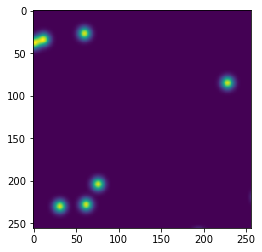

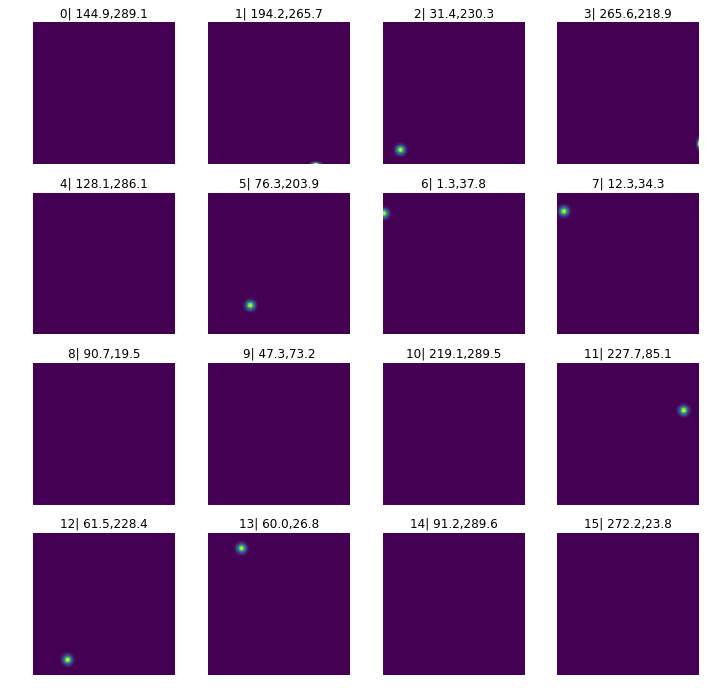

In [6]:
b = 15
joints_, heatmaps_ = joints[b].detach().cpu(), heatmaps[b].detach().cpu()
plt.imshow(heatmaps_.sum(dim=0));
plt.show()
fig,ax = plt.subplots(4,4, figsize=(12,12))
for i in range(4):
    for j in range(4):
        k = i*4 + j
        ax[i,j].imshow(heatmaps_[k])
        x,y = float(joints_[k][0]), float(joints_[k][1])
        title = f'{k}| {x:.1f},{y:.1f}'
        ax[i,j].set_title(title)
        ax[i,j].set_axis_off()

In [7]:
loss = heatmaps.sum()
loss.backward()

# heatmaps.backward(th.ones(heatmaps.size()))

In [8]:
m = (joints.grad.abs() > 1e-2).sum().type_as(joints)
print(m)
print(joints.numel())
print(m/joints.numel())

tensor(55.)
640
tensor(0.0859)


In [9]:
heatmaps[0].type

<function Tensor.type>

# Check that:

# softargmax ( heatmaps ( joints ) ) == joints

- All joints must be fully-visible

- no rounding errors must occur (joints coordinates must be divisible by feat_stride)


In [11]:
from lib.functional.generate_heatmaps import GenerateHeatmaps
from lib.functional.softargmax import IntegralSoftargmax

In [12]:
image_size = 256
heatmap_size = 64
sigma = 1

# joints = th.tensor([ # any floating values considered
#     [
#         [50.,50.], 
#         [210.3,111.1],
#     ],
#     [
#         [17.2,215.3], 
#         [235.3,43.1],
#     ]
# ])

th.manual_seed(0)
joints = th.randint(0, 56, size=(10,100,2)) * 4. + 12. # no rounding problems would arise
joints = joints.double()
joints.requires_grad = True

batch_size, num_joints = joints.size(0), joints.size(1)
joints_mask = th.ones(batch_size, num_joints, dtype=th.bool)

# print(joints)
print(joints.shape, joints_mask.shape)

torch.Size([10, 100, 2]) torch.Size([10, 100])


In [13]:
gen_hmaps = GenerateHeatmaps(image_size=(image_size, image_size),
                             heatmap_size=(heatmap_size, heatmap_size), sigma=sigma)

softargmax = IntegralSoftargmax(softmax_off=True) # softmax_off is used only when input is the distribution

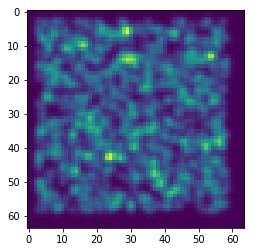

In [14]:
heatmaps = gen_hmaps(joints, joints_mask)
plt.imshow(heatmaps.detach().sum(dim=0).sum(dim=0));

In [15]:
joints_pred = softargmax(heatmaps) * image_size

print((joints - joints_pred).abs().sum() / joints.numel())

tensor(3.5829e-15, dtype=torch.float64, grad_fn=<DivBackward0>)


In [16]:
loss = joints_pred.sum()
loss.backward()

In [17]:
joints.grad

tensor([[[0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         ...,
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959]],

        [[0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         ...,
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959]],

        [[0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         ...,
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959]],

        ...,

        [[0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         ...,
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959]],

        [[0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         ...,
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959]],

        [[0.9959, 0.9959],
         [0.9959, 0.9959],
         [0.9959, 0.9959],
         ...,
 

### almost ones everywhere...